# **High Performance Content Based Recommendation Engine for Movies**

---

*Created by*

---

Nicholas

Alzmami

Naif

Adrian

# **Introducing the Dataset**

## Setting Up the Data
---


In [ ]:
# Run this to fix the surprise library problem

# Force install NumPy 1.26.x
!pip uninstall -y numpy
!pip install numpy==1.26.4

#Uninstall and reinstall scikit-surprise (compatible with NumPy 1.x)
!pip uninstall -y scikit-surprise

#Restart the runtime to make the changes take effect
import os
os.kill(os.getpid(), 9)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.1 MB/s eta 0:00:00


In [ ]:
! pip install -q sentence_transformers
!pip install -q surprise

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sentence_transformers import SentenceTransformer

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.t

In [ ]:
# Good practice Kaggle token authentication
def setup_kaggle():
  from google.colab import files
  uploaded = files.upload()
  !chmod 600 kaggle.json
  %mkdir -p /root/.kaggle/
  %mv kaggle.json /root/.kaggle/

setup_kaggle()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle

import kaggle
kaggle.api.authenticate() # Call authenticator

In [ ]:
data_path = 'bwandowando/rotten-tomatoes-9800-movie-critic-and-user-reviews'
kaggle.api.dataset_download_files(data_path, path=data_path, unzip=True)
! ls $data_path

Dataset URL: https://www.kaggle.com/datasets/bwandowando/rotten-tomatoes-9800-movie-critic-and-user-reviews
critic_reviews.csv  movies.csv	user_reviews.csv


## Movies Dataset

In [ ]:
# Load the first movies dataset (Rotten Tomatoes)
movies_path = f'{data_path}/movies.csv/movies.csv'
movies_df = pd.read_csv(movies_path, usecols=['movieId', 'movieTitle'])

# Load the second movies dataset (IMDB more detailed metadata)
metadata_path = f'harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows'
kaggle.api.dataset_download_files(metadata_path, path=metadata_path, unzip=True)
! ls $dataset_path

Dataset URL: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
bwandowando  harshitshankhdhar	sample_data


In [ ]:
metadata_path = f'{metadata_path}/imdb_top_1000.csv'

In [ ]:
metadata_df = pd.read_csv(metadata_path, usecols=[
    'Series_Title', 'Released_Year', 'Runtime', 'Genre', 'IMDB_Rating',
    'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
    'No_of_Votes', 'Gross'
])

In [ ]:
# Merge datasets on movie title (Series_Title from IMDB and movieTitle from Rotten Tomatoes)
items_df = movies_df.merge(metadata_df, left_on='movieTitle', right_on='Series_Title')

# Drop duplicate title column (Series_Title), don't need it anymore
items_df.drop(columns=['Series_Title'], inplace=True)

items_df.head(10) # This is our master items dataframe, using only movies common between the critics review dataset
# and the existing IMDB high-detailed dataset

,movieId,movieTitle,Released_Year,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,b70c2dc6-41e7-3240-a38f-5f5e5018eeb1,The Kid,1921,68 min,"Comedy, Drama, Family",8.3,"The Tramp cares for an abandoned child, but ev...",NaN,Charles Chaplin,Charles Chaplin,Edna Purviance,Jackie Coogan,Carl Miller,113314,"5,450,000"
1,13101368-55d8-30a1-9d41-4271211defbb,Nosferatu,1922,94 min,"Fantasy, Horror",7.9,Vampire Count Orlok expresses interest in a ne...,NaN,F.W. Murnau,Max Schreck,Alexander Granach,Gustav von Wangenheim,Greta Schröder,88794,NaN
2,31380a24-d8b9-309c-9919-2a296414f7d4,The Gold Rush,1925,95 min,"Adventure, Comedy, Drama",8.2,A prospector goes to the Klondike in search of...,NaN,Charles Chaplin,Charles Chaplin,Mack Swain,Tom Murray,Henry Bergman,101053,"5,450,000"
3,8e497f00-f9c0-3e6c-8526-969077b790df,Metropolis,1927,153 min,"Drama, Sci-Fi",8.3,In a futuristic city sharply divided between t...,98.0,Fritz Lang,Brigitte Helm,Alfred Abel,Gustav Fröhlich,Rudolf Klein-Rogge,159992,"1,236,166"
4,f738f015-343f-3d13-9098-b4db4e1f52d8,The General,1926,67 min,"Action, Adventure, Comedy",8.1,When Union spies steal an engineer's beloved l...,NaN,Clyde Bruckman,Buster Keaton,Buster Keaton,Marion Mack,Glen Cavender,81156,"1,033,895"
5,6d478192-b5bc-36ec-b3b3-e194ba4356a4,All Quiet on the Western Front,1930,152 min,"Drama, War",8.0,"A German youth eagerly enters World War I, but...",91.0,Lewis Milestone,Lew Ayres,Louis Wolheim,John Wray,Arnold Lucy,57318,"3,270,000"
6,5255a6c3-59bb-3fc5-b971-c232eff3f841,Frankenstein,1931,70 min,"Drama, Horror, Sci-Fi",7.8,Dr. Frankenstein dares to tamper with life and...,91.0,James Whale,Colin Clive,Mae Clarke,Boris Karloff,John Boles,65341,NaN
7,ce4faf60-7493-3977-8054-f83d3edd66ce,City Lights,1931,87 min,"Comedy, Drama, Romance",8.5,"With the aid of a wealthy erratic tippler, a d...",99.0,Charles Chaplin,Charles Chaplin,Virginia Cherrill,Florence Lee,Harry Myers,167839,"19,181"
8,4ef7258f-ae1f-3e3b-aa04-6ddb1ed6d74b,Scarface,1983,170 min,"Crime, Drama",8.3,"In 1980 Miami, a determined Cuban immigrant ta...",65.0,Brian De Palma,Al Pacino,Michelle Pfeiffer,Steven Bauer,Mary Elizabeth Mastrantonio,740911,"45,598,982"
9,e608f862-5f42-3cb1-8da6-a074e626f2ce,Freaks,1932,64 min,"Drama, Horror",7.9,A circus' beautiful trapeze artist agrees to m...,80.0,Tod Browning,Wallace Ford,Leila Hyams,Olga Baclanova,Roscoe Ates,42117,NaN


## Reviews Dataset

In [ ]:
reviews_path = f'{data_path}/critic_reviews.csv/critic_reviews.csv'
reviews_df = pd.read_csv(reviews_path, usecols=[
    'reviewId', 'criticName', 'movieId', 'reviewState'
])


# Remove rows where criticName is empty (NaN) or an empty string
reviews_df = reviews_df[reviews_df['criticName'].notna() & reviews_df['criticName'].str.strip().ne("")]

# Filter only reviews for movies that appear in the master movie metadata set (items_df)
filtered_reviews_df = reviews_df[reviews_df['movieId'].isin(items_df['movieId'])]

In [ ]:
# Merge to include movie titles by matching movieId in the ratings set with the movies set
users_df = filtered_reviews_df.merge(items_df[['movieId', 'movieTitle']], left_on='movieId', right_on='movieId')

users_df = users_df[['reviewId', 'criticName', 'movieId', 'movieTitle', 'reviewState']]

users_df.head(10) # Now we're ensured to only have reviews for movies that we have good metadata on

,reviewId,criticName,movieId,movieTitle,reviewState
0,1906341,James Berardinelli,f2f93b25-be0f-3d0e-a721-a2457dafdd47,Stand by Me,fresh
1,1906296,James Berardinelli,6d478192-b5bc-36ec-b3b3-e194ba4356a4,All Quiet on the Western Front,fresh
2,1910277,James Berardinelli,72619c50-e028-3cfe-ae53-6cb86204389c,It Happened One Night,fresh
3,1892661,Mike Barnard,8054c5a7-0cd6-33a2-a0df-a219a851862e,The 39 Steps,fresh
4,1914921,Bob Westal,4e702a02-b28e-3ac5-89f2-c241ffe2edf2,Stagecoach,fresh
5,1901502,Owen Gleiberman,18af2553-dc8f-3607-a605-92e907068433,Citizen Kane,fresh
6,1915232,Scott Nash,916f85d7-666b-32cd-8110-ff2cf925f2a7,The Maltese Falcon,fresh
7,1909195,Scott Nash,744d4aea-e6ad-3c9a-9723-ee9b10505b98,Casablanca,fresh
8,1904763,Thomas Caldwell,819e3da2-48e0-316a-ae57-4d2e2ff9dc78,Double Indemnity,fresh
9,1913941,Scott Nash,0dfcfa81-21aa-3c4e-8e94-bf55ddb0b1b2,Gilda,fresh


In [ ]:
reviews_from_Scott_Nash = users_df[(users_df["criticName"] == "Scott Nash") & (users_df["reviewState"] == "rotten")] # To ensure they have negative reviews,
reviews_from_Scott_Nash.head(10)

,reviewId,criticName,movieId,movieTitle,reviewState
47,1905878,Scott Nash,58f8d663-be4b-318f-a93e-b6ab47fa7201,Who Framed Roger Rabbit,rotten
16208,1201669,Scott Nash,6ffebc79-1c66-3aa2-95d4-e1e38538a36e,The Bourne Identity,rotten
19258,1265858,Scott Nash,31add379-9bab-343e-9482-37882dd703a7,The Ladykillers,rotten
25678,1435914,Scott Nash,e168098c-10a3-3cf5-a665-b83b42c95480,Lord of War,rotten
25823,1440797,Scott Nash,27a7230e-0f88-3555-9266-974a10cd97b2,Gladiator,rotten
25895,1440862,Scott Nash,ca99933c-62af-36ac-8e7c-27d00772b2d2,Crash,rotten
26709,1454871,Scott Nash,a46f570e-b3d7-3025-9f37-405307f322fc,Walk the Line,rotten
27572,1468798,Scott Nash,d4bc2f74-cb2e-389a-81b0-00e456b4e309,King Kong,rotten
30372,1551915,Scott Nash,ff7e770b-3db7-3caf-8149-6010b1e7cd70,The Last King of Scotland,rotten
31638,1576662,Scott Nash,fb127c78-dfa4-301f-8e12-430dce0844a2,The Pursuit of Happyness,rotten


Just as an example, here is a critic with multiple reviews.  We have focused here on his negative reviews just to get a taste of his dislikes.  (Clearly, he has poor taste, as he classified `Gladiator` as `rotten`).

## Analyzing the Reviews Dataset

In [ ]:
print(f"There are {users_df['criticName'].nunique()} individual users.")
print(f"There are {users_df['movieId'].nunique()} total films.")
print(f"There are {users_df.shape[0]} total ratings accounted for in this dataset.")

There are 6289 individual users.
There are 755 total films.
There are 119605 total ratings accounted for in this dataset.


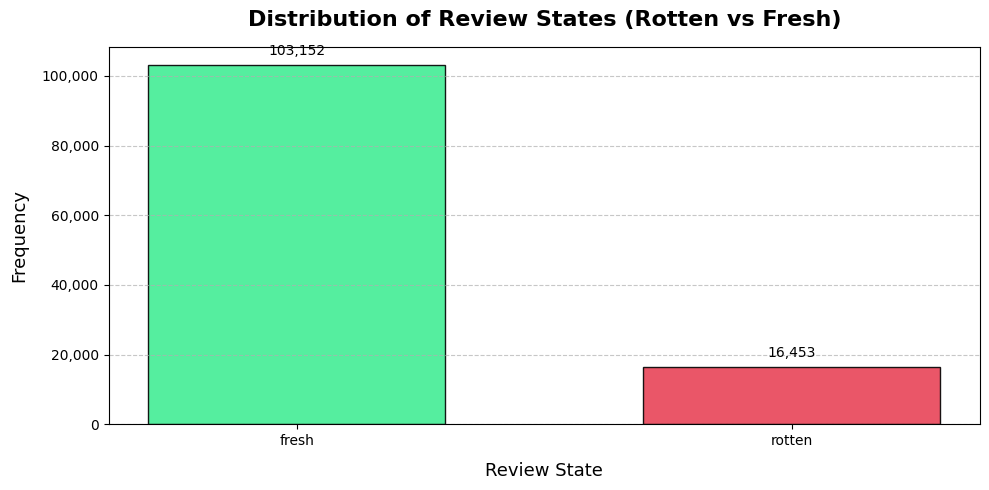

In [ ]:
# Count occurrences of each reviewState
review_state_counts = users_df['reviewState'].value_counts()

# Create a histogram (bar chart) for the distribution of reviewState
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(review_state_counts.index, review_state_counts.values, color=['#42ed95', '#e84357'], edgecolor='black', width=0.6, alpha=0.9)

# Set title and labels
ax.set_title('Distribution of Review States (Rotten vs Fresh)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Review State', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)

# Customize axes
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add numerical labels on bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Analyzing the Films Dataset

In [ ]:
items_df['Gross'] = items_df['Gross'].str.replace(',', '')
items_df['Runtime'] = items_df['Runtime'].str.split(' ').str[0]

to_num_columns = ['Released_Year', 'Gross', 'Runtime']
items_df[to_num_columns] = items_df[to_num_columns].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Various statistics computations for the movies df
num_unique_movies = items_df['movieId'].nunique()
average_runtime = items_df['Runtime'].mean()
average_release_year = items_df['Released_Year'].mean()
average_imdb_rating = items_df['IMDB_Rating'].mean()
most_common_director = items_df['Director'].mode()[0]
average_no_of_votes = items_df['No_of_Votes'].mean()
average_gross = items_df['Gross'].mean()
num_rows = items_df.shape[0]

print(f"There are {num_unique_movies} unique movies in the dataset.  Correspondingly, there are {num_rows} rows.")
print(f"The average runtime of movies is {average_runtime:.2f} minutes.")
print(f"The average release year is {average_release_year:.0f}.")
print(f"The average IMDB rating is {average_imdb_rating:.2f}.")
print(f"The most common director is {most_common_director}.")
print(f"The average number of votes per movie is {average_no_of_votes:,.0f}.")
print(f"The average gross earnings per movie are ${average_gross:,.2f}.")

There are 755 unique movies in the dataset.  Correspondingly, there are 755 rows.
The average runtime of movies is 123.35 minutes.
The average release year is 1989.
The average IMDB rating is 7.94.
The most common director is Alfred Hitchcock.
The average number of votes per movie is 330,646.
The average gross earnings per movie are $84,998,233.20.


Note that due to our cross-reference-trimming of reviews and movies, we've ensured that only movies with reviews appear in this dataframe, hence both users and items have the same number of movies.

In [ ]:
histogram_data = ['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']

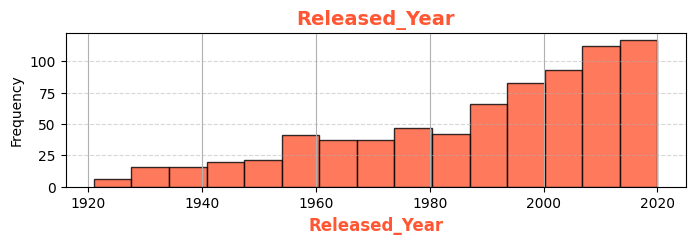

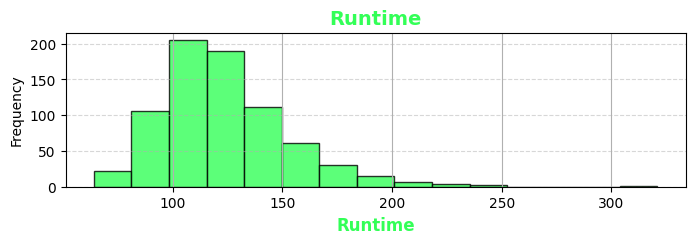

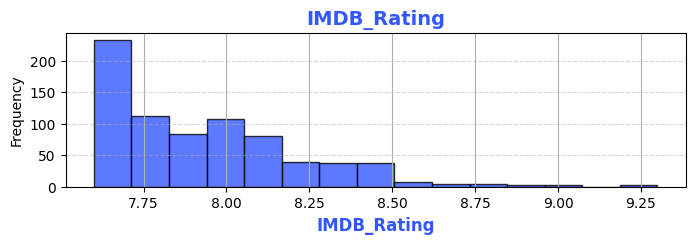

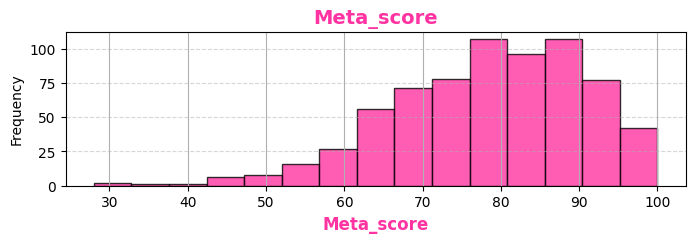

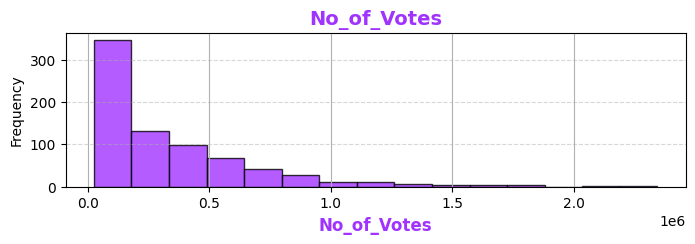

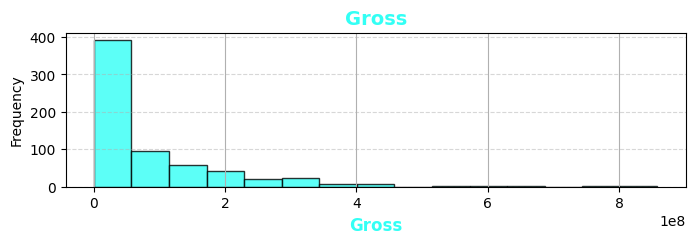

In [ ]:
# Define a color palette
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#33FFF5']

# Loop through histogram data and generate histograms with varied colors
for i, col in enumerate(histogram_data):
    plt.figure(figsize=(8, 2))

    # Use a cycling color from the palette
    color = colors[i % len(colors)]

    items_df[col].hist(bins=15, color=color, edgecolor='black', alpha=0.8)
    plt.xlabel(col, fontsize=12, fontweight='bold', color=color)
    plt.ylabel("Frequency", fontsize=10)
    plt.title(f"{col}", fontsize=14, fontweight='bold', color=color)

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

In [ ]:
items_df['Genre_List'] = items_df['Genre'].apply(lambda x: x.split(', '))
items_df_exploded = items_df.explode('Genre_List')
px.histogram(items_df_exploded, x='Genre_List', height=400, title='Movie count by genre').update_xaxes(categoryorder="total descending")

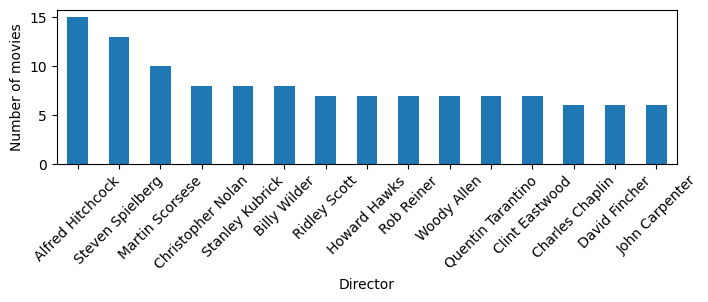

In [ ]:
plt.subplots(figsize=(8,2))
items_df.groupby('Director').size().sort_values(ascending=False).head(15).plot.bar();
plt.xticks(rotation=45);
plt.ylabel('Number of movies');

px.histogram(items_df, x='Director', height=400, title='Movie count by diretor').update_xaxes(categoryorder="total descending")

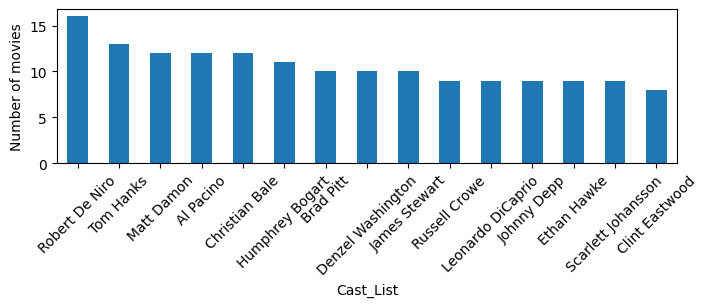

In [ ]:
items_df['Cast_List'] = items_df[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()
items_df_cast_exploded = items_df.explode('Cast_List')

plt.subplots(figsize=(8,2))
items_df_cast_exploded.groupby('Cast_List').size().sort_values(ascending=False).head(15).plot.bar();
plt.xticks(rotation=45);
plt.ylabel('Number of movies');

px.histogram(items_df_cast_exploded, x='Cast_List', height=400, title='Movie count by cast').update_xaxes(categoryorder="total descending")

# **Creating the Content-Based Recommender**

## Numerical Similarity Portion

In [ ]:
items_df.set_index('movieTitle', inplace=True)
items_df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,754.000000,755.000000,755.000000,695.000000,7.550000e+02,6.540000e+02
mean,1989.293103,123.350993,7.936821,78.342446,3.306461e+05,8.499823e+07
std,24.167197,29.318022,0.282365,12.334699,3.468352e+05,1.129097e+08
min,1921.000000,64.000000,7.600000,28.000000,2.519800e+04,3.600000e+03
25%,1973.000000,102.000000,7.700000,70.000000,8.040150e+04,1.000000e+07
50%,1996.000000,119.000000,7.900000,79.000000,2.148820e+05,4.297389e+07
75%,2009.000000,137.000000,8.100000,88.000000,4.642895e+05,1.165892e+08
max,2020.000000,321.000000,9.300000,100.000000,2.343110e+06,8.583730e+08


In [ ]:
items_num_df = items_df[histogram_data]
items_num_df.head()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
movieTitle,,,,,,
The Kid,1921.0,68,8.3,NaN,113314,5450000.0
Nosferatu,1922.0,94,7.9,NaN,88794,NaN
The Gold Rush,1925.0,95,8.2,NaN,101053,5450000.0
Metropolis,1927.0,153,8.3,98.0,159992,1236166.0
The General,1926.0,67,8.1,NaN,81156,1033895.0


In [ ]:
euclidean_sim_num = pairwise_distances(items_num_df, items_num_df, metric='nan_euclidean', force_all_finite='allow-nan')
euclidean_sim_num_df = pd.DataFrame(euclidean_sim_num, columns=items_df.index)
euclidean_sim_num_df.index = items_df.index

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
euclidean_sim_num_df.shape

(755, 755)

In [ ]:
euclidean_sim_num_df.head()

movieTitle,The Kid,Nosferatu,The Gold Rush,Metropolis,The General,All Quiet on the Western Front,Frankenstein,City Lights,Scarface,Freaks,...,Funny Games,All Quiet on the Western Front,Control,The Visitor,The Innocents,The Little Mermaid,Inside Man,The Color Purple,Stalker,Soul
movieTitle,,,,,,,,,,,,,,,,,,,,,
The Kid,0.000000e+00,30030.761158,1.343129e+04,4.616307e+06,4.837729e+06,2.388858e+06,58754.687046,5.949464e+06,4.398638e+07,87198.161788,...,59101.382122,2.388858e+06,5.015731e+06,4.352280e+06,3.105931e+06,1.162197e+08,9.099184e+07,1.018960e+08,5.713051e+06,56163.270124
Nosferatu,3.003076e+04,0.000000,1.501415e+04,8.719942e+04,9.354661e+03,3.855014e+04,28723.958624,9.680996e+04,7.986770e+05,57167.429481,...,29070.694447,3.855014e+04,3.329487e+04,5.786929e+04,7.567333e+04,1.823670e+05,3.073657e+05,1.282720e+04,3.447796e+04,86193.953695
The Gold Rush,1.343129e+04,15014.147882,0.000000e+00,4.616475e+06,4.837650e+06,2.388551e+06,43738.100184,5.949614e+06,4.398659e+07,72181.574236,...,44084.782721,2.388551e+06,5.015597e+06,4.352059e+06,3.105551e+06,1.162197e+08,9.099188e+07,1.018960e+08,5.713076e+06,71179.817793
Metropolis,4.616307e+06,87199.415510,4.616475e+06,0.000000e+00,2.378117e+05,2.036424e+06,103685.015823,1.217010e+06,4.436662e+07,129125.631360,...,103995.031357,2.036424e+06,3.776299e+05,8.187113e+06,1.386228e+06,1.103073e+08,8.727751e+07,9.723173e+07,1.098039e+06,907.121187
The General,4.837729e+06,9354.661061,4.837650e+06,2.378117e+05,0.000000e+00,2.449669e+06,19369.341461,1.115612e+06,4.882396e+07,47812.815741,...,19716.198654,2.449669e+06,1.790952e+05,9.189273e+06,1.734124e+06,1.210573e+08,9.582952e+07,1.067336e+08,8.763265e+05,95548.549047


In [ ]:
recommendations_df = items_num_df.copy()
recommendations_df['distance'] = euclidean_sim_num_df.loc['Nosferatu']
recommendations_df.sort_values('distance').head(10)

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,distance
movieTitle,,,,,,,
Nosferatu,1922.0,94,7.9,NaN,88794,NaN,0.000000
Fantasia,1940.0,125,7.7,96.0,88662,76408097.0,167.521640
Persepolis,2007.0,96,8.0,90.0,88656,4445756.0,198.518305
The King of Comedy,1982.0,109,7.8,73.0,88511,2500000.0,354.783053
Mississippi Burning,1988.0,128,7.8,65.0,88214,34603943.0,716.148029
Do the Right Thing,1989.0,120,8.0,93.0,89429,27545445.0,782.678095
Blood Simple,1984.0,99,7.6,82.0,87745,2150000.0,1287.014038
The Magnificent Seven,1960.0,128,7.7,74.0,87719,4905000.0,1318.081014
The Magnificent Seven,1960.0,128,7.7,74.0,87719,4905000.0,1318.081014


In [ ]:
sc = StandardScaler()
items_num_norm_df = pd.DataFrame(sc.fit_transform(items_df[histogram_data]), columns=histogram_data)

This normalization is useful to mitigate the effects that certain statistics are significantly more varying on a larger scale (ex. Gross dollars) compared to something like IMDB rating which is limited to the 1-10 range.

In [ ]:
items_num_norm_df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,7.540000e+02,7.550000e+02,7.550000e+02,6.950000e+02,7.550000e+02,6.540000e+02
mean,1.997812e-15,-1.505786e-16,-2.333968e-15,1.022364e-16,3.764465e-17,-5.432284e-17
std,1.000664e+00,1.000663e+00,1.000663e+00,1.000720e+00,1.000663e+00,1.000765e+00
min,-2.827735e+00,-2.025728e+00,-1.193649e+00,-4.084307e+00,-8.812559e-01,-7.533423e-01
25%,-6.746301e-01,-7.287377e-01,-8.392622e-01,-6.768267e-01,-7.219869e-01,-6.647401e-01
50%,2.777049e-01,-1.485052e-01,-1.304893e-01,5.334767e-02,-3.339939e-01,-3.724790e-01
75%,8.159812e-01,4.658587e-01,5.782836e-01,7.835221e-01,3.855778e-01,2.800038e-01
max,1.271446e+00,6.746022e+00,4.830921e+00,1.757088e+00,5.806209e+00,6.854738e+00


In [ ]:
euclidean_sim_num_norm = pairwise_distances(items_num_norm_df, items_num_norm_df, metric='nan_euclidean', force_all_finite='allow-nan')
euclidean_sim_num_norm_df = pd.DataFrame(euclidean_sim_num_norm, columns=items_df.index)
euclidean_sim_num_norm_df.index = items_df.index
euclidean_sim_num_norm_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



movieTitle,The Kid,Nosferatu,The Gold Rush,Metropolis,The General,All Quiet on the Western Front,Frankenstein,City Lights,Scarface,Freaks,...,Funny Games,All Quiet on the Western Front,Control,The Visitor,The Innocents,The Little Mermaid,Inside Man,The Color Purple,Stalker,Soul
movieTitle,,,,,,,,,,,,,,,,,,,,,
The Kid,0.000000,2.050729,1.097371,3.193367,0.817209,3.379145,2.236629,1.160041,5.151586,1.848398,...,5.187461,3.379145,4.974595,4.946250,2.926786,4.292782,5.349137,4.833382,4.407544,5.270112
Nosferatu,2.050729,0.000000,1.312338,3.037188,1.438500,2.498733,1.187465,2.674657,5.290194,1.362736,...,4.063327,2.498733,4.551159,4.525305,2.051942,3.705126,4.771597,4.085024,4.259200,5.057331
The Gold Rush,1.097371,1.312338,0.000000,2.213136,1.120063,2.283794,2.052997,1.251893,4.379099,1.882582,...,4.519388,2.283794,4.317155,4.405575,2.273346,3.911680,4.664682,3.937611,3.504228,4.845983
Metropolis,3.193367,3.037188,2.213136,0.000000,3.317546,1.248000,3.729278,2.368863,3.980554,4.029112,...,5.198959,1.248000,4.396208,4.735145,3.033077,4.485180,4.645206,3.512748,2.417763,4.909248
The General,0.817209,1.438500,1.120063,3.317546,0.000000,3.207782,1.333643,1.759853,5.162646,0.938549,...,4.540270,3.207782,4.487993,4.382003,2.329910,3.699619,4.868032,4.471462,4.308015,4.970131


Notice that a proof of effective function of this numerical similarity is that the diagonal distance (between a movie and itself's numerical values) is net zero.

In [ ]:
recommendations_df['distance'] = euclidean_sim_num_norm_df.loc['Nosferatu']
recommendations_df.sort_values('distance').head(10)

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,distance
movieTitle,,,,,,,
Nosferatu,1922.0,94,7.9,NaN,88794,NaN,0.000000
King Kong,1933.0,100,7.9,90.0,78991,10000000.0,0.612600
King Kong,1933.0,100,7.9,90.0,78991,10000000.0,0.612600
King Kong,1933.0,100,7.9,90.0,78991,10000000.0,0.612600
The Thin Man,1934.0,91,8.0,86.0,26642,NaN,0.789090
The Adventures of Robin Hood,1938.0,102,7.9,97.0,47175,3981000.0,0.889837
His Girl Friday,1940.0,92,7.9,NaN,53667,296000.0,0.924996
The Lady Vanishes,1938.0,96,7.8,98.0,47400,NaN,0.935476
Stagecoach,1939.0,96,7.8,93.0,43621,NaN,0.981868


## Categorical Similarity Portion

In [ ]:
categorical_cols = ['Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']
items_cat_df = items_df[categorical_cols]
items_cat_df.head()

,Genre,Director,Star1,Star2,Star3,Star4
movieTitle,,,,,,
The Kid,"Comedy, Drama, Family",Charles Chaplin,Charles Chaplin,Edna Purviance,Jackie Coogan,Carl Miller
Nosferatu,"Fantasy, Horror",F.W. Murnau,Max Schreck,Alexander Granach,Gustav von Wangenheim,Greta Schröder
The Gold Rush,"Adventure, Comedy, Drama",Charles Chaplin,Charles Chaplin,Mack Swain,Tom Murray,Henry Bergman
Metropolis,"Drama, Sci-Fi",Fritz Lang,Brigitte Helm,Alfred Abel,Gustav Fröhlich,Rudolf Klein-Rogge
The General,"Action, Adventure, Comedy",Clyde Bruckman,Buster Keaton,Buster Keaton,Marion Mack,Glen Cavender


To figure out how close the cast and creators of two different films are which is a good indicator of how much the nature of the films / the vibes resemble each other.  Ex. with an actor like Al Pacino, you are likely to encounter filns related to mobs, crime, etc.  and they may have other A-list actors like Robert de Niro in them.

In [ ]:
items_cat_df = items_cat_df.apply(lambda x: x.str.lower())
items_cat_df = items_cat_df.apply(lambda x: x.str.replace(' ', ''))
items_cat_df = items_cat_df.apply(lambda x: x.str.replace(',', ' '))

items_cat_df.head()

,Genre,Director,Star1,Star2,Star3,Star4
movieTitle,,,,,,
The Kid,comedy drama family,charleschaplin,charleschaplin,ednapurviance,jackiecoogan,carlmiller
Nosferatu,fantasy horror,f.w.murnau,maxschreck,alexandergranach,gustavvonwangenheim,gretaschröder
The Gold Rush,adventure comedy drama,charleschaplin,charleschaplin,mackswain,tommurray,henrybergman
Metropolis,drama sci-fi,fritzlang,brigittehelm,alfredabel,gustavfröhlich,rudolfklein-rogge
The General,action adventure comedy,clydebruckman,busterkeaton,busterkeaton,marionmack,glencavender


For consistency in between different capitalization permutations / combinations of different film entries

In [ ]:
items_cat_df['soup'] = items_cat_df[categorical_cols].agg(' '.join, axis=1)

pd.set_option('display.max_colwidth', 200)
items_cat_df.head()

,Genre,Director,Star1,Star2,Star3,Star4,soup
movieTitle,,,,,,,
The Kid,comedy drama family,charleschaplin,charleschaplin,ednapurviance,jackiecoogan,carlmiller,comedy drama family charleschaplin charleschaplin ednapurviance jackiecoogan carlmiller
Nosferatu,fantasy horror,f.w.murnau,maxschreck,alexandergranach,gustavvonwangenheim,gretaschröder,fantasy horror f.w.murnau maxschreck alexandergranach gustavvonwangenheim gretaschröder
The Gold Rush,adventure comedy drama,charleschaplin,charleschaplin,mackswain,tommurray,henrybergman,adventure comedy drama charleschaplin charleschaplin mackswain tommurray henrybergman
Metropolis,drama sci-fi,fritzlang,brigittehelm,alfredabel,gustavfröhlich,rudolfklein-rogge,drama sci-fi fritzlang brigittehelm alfredabel gustavfröhlich rudolfklein-rogge
The General,action adventure comedy,clydebruckman,busterkeaton,busterkeaton,marionmack,glencavender,action adventure comedy clydebruckman busterkeaton busterkeaton marionmack glencavender


In [ ]:
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(items_cat_df['soup'])

In [ ]:
count_matrix.shape

(755, 2276)

In [ ]:
count_matrix_df = pd.DataFrame(count_matrix.toarray(), columns=vectorizer.get_feature_names_out())
count_matrix_df.index = items_df.index
count_matrix_df.head()

,aamirkhan,aaroneckhart,aaronsorkin,aarontaylor,abigailbreslin,abrahamattah,abrams,action,adambaldwin,adamdriver,...,zacksnyder,zanuck,zaziebeetz,zeppomarx,zoesaldana,zooeydeschanel,zoyaakhtar,zoëkravitz,álvaroguerrero,érictoledano
movieTitle,,,,,,,,,,,,,,,,,,,,,
The Kid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nosferatu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Gold Rush,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Metropolis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The General,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cosine_sim_cat = pairwise_distances(count_matrix_df, count_matrix_df, metric='cosine')
cosine_sim_cat_df = pd.DataFrame(cosine_sim_cat, columns=items_df.index)
cosine_sim_cat_df.index = items_df.index
cosine_sim_cat_df.head()

movieTitle,The Kid,Nosferatu,The Gold Rush,Metropolis,The General,All Quiet on the Western Front,Frankenstein,City Lights,Scarface,Freaks,...,Funny Games,All Quiet on the Western Front,Control,The Visitor,The Innocents,The Little Mermaid,Inside Man,The Color Purple,Stalker,Soul
movieTitle,,,,,,,,,,,,,,,,,,,,,
The Kid,1.110223e-16,1.000000e+00,4.000000e-01,0.894591,9.000000e-01,0.880477,0.894591,0.400000,0.880477,0.880477,...,0.888197,0.880477,0.888197,0.870901,1.000000,0.894591,0.888197,0.870901,0.888197,0.888197
Nosferatu,1.000000e+00,2.220446e-16,1.000000e+00,1.000000,1.000000e+00,1.000000,0.874012,1.000000,1.000000,0.857143,...,1.000000,1.000000,1.000000,1.000000,0.845697,0.874012,1.000000,1.000000,1.000000,1.000000
The Gold Rush,4.000000e-01,1.000000e+00,1.110223e-16,0.894591,8.000000e-01,0.880477,0.894591,0.400000,0.880477,0.880477,...,0.888197,0.880477,0.888197,0.870901,1.000000,1.000000,0.888197,0.870901,0.888197,0.776393
Metropolis,8.945907e-01,1.000000e+00,8.945907e-01,0.000000,1.000000e+00,0.874012,0.666667,0.894591,0.874012,0.874012,...,0.882149,0.874012,0.882149,0.863917,1.000000,1.000000,0.882149,0.863917,0.646447,1.000000
The General,9.000000e-01,1.000000e+00,8.000000e-01,1.000000,1.110223e-16,1.000000,1.000000,0.900000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.776393


In [ ]:
recommendations_cat_df = items_cat_df.copy()
recommendations_cat_df['distance'] = cosine_sim_cat_df.loc['The Godfather']
recommendations_cat_df.sort_values('distance').head(10)

,Genre,Director,Star1,Star2,Star3,Star4,soup,distance
movieTitle,,,,,,,,
The Godfather,crime drama,francisfordcoppola,marlonbrando,alpacino,jamescaan,dianekeaton,crime drama francisfordcoppola marlonbrando alpacino jamescaan dianekeaton,3.330669e-16
Scarface,crime drama,briandepalma,alpacino,michellepfeiffer,stevenbauer,maryelizabethmastrantonio,crime drama briandepalma alpacino michellepfeiffer stevenbauer maryelizabethmastrantonio,5.714286e-01
Scarface,crime drama,briandepalma,alpacino,michellepfeiffer,stevenbauer,maryelizabethmastrantonio,crime drama briandepalma alpacino michellepfeiffer stevenbauer maryelizabethmastrantonio,5.714286e-01
Heat,crime drama thriller,michaelmann,alpacino,robertdeniro,valkilmer,jonvoight,crime drama thriller michaelmann alpacino robertdeniro valkilmer jonvoight,5.991081e-01
Dog Day Afternoon,biography crime drama,sidneylumet,alpacino,johncazale,penelopeallen,sullyboyar,biography crime drama sidneylumet alpacino johncazale penelopeallen sullyboyar,5.991081e-01
Serpico,biography crime drama,sidneylumet,alpacino,johnrandolph,jackkehoe,biffmcguire,biography crime drama sidneylumet alpacino johnrandolph jackkehoe biffmcguire,5.991081e-01
Apocalypse Now,drama mystery war,francisfordcoppola,martinsheen,marlonbrando,robertduvall,fredericforrest,drama mystery war francisfordcoppola martinsheen marlonbrando robertduvall fredericforrest,5.991081e-01
Carlito's Way,crime drama thriller,briandepalma,alpacino,seanpenn,penelopeannmiller,johnleguizamo,crime drama thriller briandepalma alpacino seanpenn penelopeannmiller johnleguizamo,5.991081e-01
Donnie Brasco,biography crime drama,mikenewell,alpacino,johnnydepp,michaelmadsen,brunokirby,biography crime drama mikenewell alpacino johnnydepp michaelmadsen brunokirby,5.991081e-01


Movies with the closest cast and direction to The Godfather, for instance.

## Text Similarity Portion using BERT

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(items_df['Overview'], show_progress_bar=False)

embeddings.shape

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sentence_transformers/SentenceTransformer.py:587: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



(755, 768)

BERT as a pretrained sentence transformer, good at extracting semantic meaning and embedding as a vector.  Can then use cosine similarity to compare these meaning-vectors.

In [ ]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.index = items_df.index
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
movieTitle,,,,,,,,,,,,,,,,,,,,,
The Kid,-0.572892,-0.861577,0.415992,-1.081999,0.065994,-0.156841,0.501958,-0.638729,0.069869,0.528984,...,-0.417913,-0.062132,1.004737,-0.186935,-0.166098,-0.985742,-0.572467,-0.308225,0.291038,0.105297
Nosferatu,0.211810,-0.217935,0.839744,-1.783939,-0.334131,-0.546198,0.430698,-0.221268,0.682442,-0.769032,...,-1.025623,-0.402445,-0.609762,0.843134,-0.160442,-0.025212,0.048875,-0.942956,-0.060233,-1.014903
The Gold Rush,-0.251950,-0.130943,0.486162,-0.314323,0.072313,0.162164,-0.251191,0.015237,0.684714,-0.185187,...,-0.237468,-0.163377,-0.037259,0.451102,0.089288,0.628023,0.261406,-0.116641,-0.043143,-0.872278
Metropolis,-0.509683,-0.577395,0.745709,-1.083297,-0.461535,-0.445884,-0.720095,-0.356094,1.389957,-1.253947,...,-0.077809,-0.176028,-0.390644,0.264256,0.090817,-0.301077,-0.129733,-0.046411,0.496090,-0.577513
The General,-0.278276,-0.311699,-0.860004,-0.150234,0.302271,-0.308385,0.024529,0.067380,1.024214,0.506085,...,-0.508305,0.094925,0.077563,0.388050,0.109823,-0.450953,0.408253,-0.392815,0.430546,-1.068579


In [ ]:
sc = StandardScaler()
embeddings_norm = sc.fit_transform(embeddings_df)

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# 1. Textual similarity matrix using cosine distance
textual_sim = cosine_distances(embeddings_norm)
textual_sim_df = pd.DataFrame(textual_sim, index=items_df.index, columns=items_df.index)

In [ ]:
# 2. Get top recommendations based on text similarity for a given movie
example_movie_title = 'The Godfather'
top_text_recs = textual_sim_df.loc[example_movie_title].sort_values().iloc[1:11]
text_recommendations_df = pd.DataFrame({
    'movieTitle': top_text_recs.index,
    'similarity_score': top_text_recs.values
})
print(f"Top 10 textually similar movies to '{example_movie_title}':")
print(text_recommendations_df)

Top 10 textually similar movies to 'The Godfather':
                    movieTitle  similarity_score
0     The Pursuit of Happyness          0.478254
1        Manchester by the Sea          0.510901
2                       Haider          0.517611
3  Baahubali 2: The Conclusion          0.566216
4                   Knives Out          0.571241
5                The Lion King          0.598950
6                The Lion King          0.598950
7                     Big Fish          0.605708
8                 Citizen Kane          0.628981
9                 A Bronx Tale          0.632042


## Projecting 2D Space Similarity using PCA

In [ ]:
from matplotlib import cm
from matplotlib.colors import to_hex, to_rgb
import numpy as np

# Ordered genre list (most negative emotion causing to most positive, standard consensus)
genre_list = ['Horror', 'War', 'Crime', 'Thriller', 'Mystery', 'Drama', 'Film-Noir', 'History',
 'Sci-Fi', 'Western', 'Action', 'Adventure', 'Fantasy', 'Biography', 'Sport',
 'Animation', 'Music', 'Romance', 'Comedy', 'Musical', 'Family']

# Create color map along a spectrum using matplotlib (purple -> red)
cmap = cm.get_cmap('plasma', len(genre_list))
genre_color_map = {
    genre: to_rgb(cmap(i)) for i, genre in enumerate(genre_list)
}

<ipython-input-58-3410f3c41f57>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [ ]:
def average_rgb_color(genres):
    valid_colors = [genre_color_map.get(g) for g in genres if g in genre_color_map]
    if not valid_colors:
        return (0.5, 0.5, 0.5)  # neutral gray fallback
    avg_rgb = np.mean(valid_colors, axis=0)
    return avg_rgb

# If needed, split genres
items_df['Genre_List'] = items_df['Genre'].apply(lambda x: x.split(', '))

# Compute average RGB for each movie (with a)
items_df['Avg_RGB'] = items_df['Genre_List'].apply(average_rgb_color)

# Convert RGB tuple to hex for plotting
items_df['Color_Hex'] = items_df['Avg_RGB'].apply(lambda rgb: to_hex(rgb))

In [ ]:
# embeddings_norm comes from embedding text with BERT + StandardScaler
pca = PCA(n_components=2)
embeddings_2D = pca.fit_transform(embeddings_norm)
pca_df = pd.DataFrame(embeddings_2D, columns=['PC1', 'PC2'], index=items_df.index)

In [ ]:
# Join with PCA projection
plot_df = pca_df.copy()
plot_df['movieTitle'] = plot_df.index
plot_df['Color_Hex'] = items_df['Color_Hex']

# Plot using RGB-blended color
fig = px.scatter(
    plot_df,
    x='PC1',
    y='PC2',
    hover_name='movieTitle',
    color=plot_df['Color_Hex'],
    color_discrete_map='identity',  # Use actual hex colors
    title='2D PCA of Movie Overviews (Blended Genre Colors)',
    width=800,
    height=600
)
fig.show()

## Hybridizing Numerical, Categorial, and Text Similarity

In [ ]:
# Convert distances into ranks per similarity type (lower distance = higher similarity = lower rank)
num_ranks = euclidean_sim_num_norm_df.rank(axis=1, method='min')
cat_ranks = cosine_sim_cat_df.rank(axis=1, method='min')
text_ranks = textual_sim_df.rank(axis=1, method='min')

# Sum of ranks (lower total = higher similarity)
hybrid_rank_df = num_ranks + cat_ranks + text_ranks

# Final hybrid top recommendations
hybrid_top_recs = hybrid_rank_df.loc[example_movie_title].sort_values().iloc[1:11]
final_hybrid_df = pd.DataFrame({
    'movieTitle': hybrid_top_recs.index,
    'rank_score': hybrid_top_recs.values
})

Note: above is the dataframe which is used as our recommender predicter.  This means that we can perform predictions on whether User X will like Movie Y based on Movie Y's similarity is stronger for movies that User X likes vs. dislikes.  This will be tackled in a subsequent section.

In [ ]:
print(f"Top 10 hybrid similar movies to '{example_movie_title}':")
print(final_hybrid_df)

Top 10 hybrid similar movies to 'The Godfather':
                    movieTitle  rank_score
0      The Wolf of Wall Street        84.0
1                   Goodfellas       130.0
2                     Scarface       146.0
3                     Scarface       146.0
4  Once Upon a Time in America       174.0
5           American History X       227.0
6                   Knives Out       235.0
7          There Will Be Blood       255.0
8            On the Waterfront       261.0
9                 The Irishman       264.0


## Recommender System by User

In [ ]:
def get_user_recommendations(user_name, users_df, hybrid_rank_df, top_n=10):
    user_reviews = users_df[users_df['criticName'] == user_name]

    fresh_movies = user_reviews[user_reviews['reviewState'] == 'fresh']['movieTitle'].dropna().unique()
    rotten_movies = user_reviews[user_reviews['reviewState'] == 'rotten']['movieTitle'].dropna().unique()
    seen_movies = set(fresh_movies).union(rotten_movies)

    def get_avg_similar_movies(movie_list):
        sim_scores = {}
        for movie in movie_list:
            # Check clearly if movie exists and is correctly indexed
            if movie not in hybrid_rank_df.index:
                continue
            scores = hybrid_rank_df.loc[movie]
            if isinstance(scores, pd.DataFrame):
                scores = scores.iloc[0]  # Take first row if duplicated
            for title, score in scores.items():
                if title == movie or pd.isna(score):
                    continue
                sim_scores.setdefault(title, []).append(score)

        # Average scores clearly, skipping any problematic cases
        avg_scores = []
        for title, score_list in sim_scores.items():
            if title in seen_movies:
                continue
            clean_scores = [score for score in score_list if pd.notna(score)]
            if clean_scores:
                avg_scores.append((title, np.mean(clean_scores)))

        # Sort clearly from smallest (most similar) to largest
        avg_scores.sort(key=lambda x: x[1])
        return avg_scores[:top_n]

    # Generate clearly separated recommendations
    recommend_list = get_avg_similar_movies(fresh_movies)
    avoid_list = get_avg_similar_movies(rotten_movies)

    # Final recommendation dataframes
    recommended_df = pd.DataFrame(recommend_list, columns=['movieTitle', 'avg_similarity_to_liked'])
    avoid_df = pd.DataFrame(avoid_list, columns=['movieTitle', 'avg_similarity_to_disliked'])

    return recommended_df, avoid_df

In [ ]:
user_name = 'Scott Nash'
recommended_df, avoid_df = get_user_recommendations(user_name, users_df, hybrid_rank_df, top_n=10)

print(f"\nTop Recommended Movies for '{user_name}':")
print(recommended_df)

print(f"\nMovies to Avoid Based on '{user_name}' Dislikes:")
print(avoid_df)


Top Recommended Movies for 'Scott Nash':
           movieTitle  avg_similarity_to_liked
0    The Untouchables               683.836634
1  Dead Poets Society               706.920792
2    The Elephant Man               734.851485
3       Donnie Brasco               736.871287
4              Misery               739.524752
5        3:10 to Yuma               740.599010
6   Dog Day Afternoon               749.886139
7       Almost Famous               749.985149
8        The Wrestler               755.920792
9          Life of Pi               757.158416

Movies to Avoid Based on 'Scott Nash' Dislikes:
           movieTitle  avg_similarity_to_disliked
0       Donnie Brasco                  602.785714
1        3:10 to Yuma                  603.285714
2          Awakenings                  639.714286
3               Glory                  649.500000
4              Misery                  656.071429
5   Road to Perdition                  659.428571
6             Ed Wood                  660

In [ ]:
# Nick's personal favorite movies
my_fresh_movies = [
    "Braveheart", "Dances with Wolves", "The Dark Knight", "The Departed",
    "Django Unchained", "Eyes Wide Shut", "Face/Off", "Gladiator",
    "Gangs of New York", "Inglourious Basterds", "Kingdom of Heaven",
    "The Last Samurai", "Master and Commander: The Far Side of the World",
    "Midnight in Paris", "Once Upon a Time in Hollywood",
    "Pirates of the Caribbean: The Curse of the Black Pearl",
    "The Prestige", "Pulp Fiction", "Saving Private Ryan",
    "Se7en", "Schindler's List", "The Shawshank Redemption",
    "Troy", "The Untouchables"
]

# Movies I've already seen
seen_movies = set(my_fresh_movies)

# Re-use existing hybrid_rank_df similarity matrix (we built earlier)

def personal_recommendations(favorite_movies, hybrid_rank_df, seen_movies, top_n=10):
    sim_scores = {}
    for movie in favorite_movies:
        if movie not in hybrid_rank_df.index:
            continue
        scores = hybrid_rank_df.loc[movie]
        if isinstance(scores, pd.DataFrame):
            scores = scores.iloc[0]  # Take first row if duplicated
        for title, score in scores.items():
            if title == movie or pd.isna(score):
                continue
            sim_scores.setdefault(title, []).append(score)

    # Average similarity clearly
    avg_scores = []
    for title, score_list in sim_scores.items():
        if title in seen_movies:
            continue
        clean_scores = [score for score in score_list if pd.notna(score)]
        if clean_scores:
            avg_scores.append((title, np.mean(clean_scores)))

    # Sort recommendations clearly from smallest (most similar) to largest
    avg_scores.sort(key=lambda x: x[1])
    return pd.DataFrame(avg_scores[:top_n], columns=['movieTitle', 'avg_similarity_score'])

# Run your personal recommendations
my_recs = personal_recommendations(my_fresh_movies, hybrid_rank_df, seen_movies, top_n=10)

print("Movie Recommendations:\n")
print(my_recs)


Movie Recommendations:

                        movieTitle  avg_similarity_score
0                Kill Bill: Vol. 1            514.933333
1                   Ford v Ferrari            540.933333
2                         Scarface            552.200000
3               The Imitation Game            570.533333
4                American Gangster            573.400000
5                L.A. Confidential            582.000000
6                   The Green Mile            594.000000
7  One Flew Over the Cuckoo's Nest            594.333333
8                          Platoon            597.933333
9                  Black Hawk Down            600.066667


This recommender has clearly picked up on my fondness for famous director, blockbuster, movies that have some critical acclaim and fame in cinema.  Moreover, of these recommendations I have seen all these films except 4,5,7 (which I believe I should at some point).  Not to mention that I have absolutely loved all of these recommended movies--the ones that I have seen.

This serves as anecdotal evidence that the content-based recommender is working very well.

## Predictions of Content-Based Recommender

In [ ]:
# Smaller random sample for quick iterations
users_df_small = users_df.sample(frac=0.1, random_state=42).reset_index(drop=True)

# Shrink items_df accordingly
small_movie_titles = users_df_small['movieTitle'].unique()
items_df_small = items_df.loc[items_df.index.intersection(small_movie_titles)].copy()

# Smaller hybrid similarity matrix
hybrid_rank_df_small = hybrid_rank_df.loc[items_df_small.index, items_df_small.index]

# Convert hybrid similarity to dictionary for safe access
hybrid_rank_dict_small = hybrid_rank_df_small.to_dict()

<ipython-input-53-74b972fab4ee>:12: UserWarning:

DataFrame columns are not unique, some columns will be omitted.



In [ ]:
def predict_user_movie_rating(user, movie, users_df, hybrid_rank_dict):
    user_reviews = users_df[users_df['criticName'] == user]

    fresh_movies = user_reviews[user_reviews['reviewState'] == 'fresh']['movieTitle'].tolist()
    rotten_movies = user_reviews[user_reviews['reviewState'] == 'rotten']['movieTitle'].tolist()

    def safe_avg_similarity(movie_list):
        sims = []
        for m in movie_list:
            try:
                score = hybrid_rank_dict[movie][m]
                if pd.notna(score):
                    sims.append(score)
            except KeyError:
                continue
        return np.mean(sims) if sims else np.nan

    avg_fresh = safe_avg_similarity(fresh_movies)
    avg_rotten = safe_avg_similarity(rotten_movies)

    if np.isnan(avg_fresh) and np.isnan(avg_rotten):
        return None
    if np.isnan(avg_rotten) or (avg_fresh < avg_rotten):
        return 'fresh'
    else:
        return 'rotten'

In [ ]:
predictions_small = []

for idx, row in users_df_small.iterrows():
    user = row['criticName']
    movie = row['movieTitle']
    actual_rating = row['reviewState']
    predicted_rating = predict_user_movie_rating(
        user, movie, users_df_small, hybrid_rank_dict_small
    )

    if predicted_rating is not None:
        predictions_small.append({
            'user': user,
            'movie': movie,
            'actual': actual_rating,
            'predicted': predicted_rating,
            'correct': actual_rating == predicted_rating
        })

predictions_df_small = pd.DataFrame(predictions_small)
print(predictions_df_small.head())

            user                 movie actual predicted  correct
0      Clay Cane                  Argo  fresh     fresh     True
1      Matt Neal     Bohemian Rhapsody  fresh     fresh     True
2  Travis Hopson              Hamilton  fresh     fresh     True
3    Dan Jardine           The Killing  fresh     fresh     True
4    Ella Taylor  The Bourne Ultimatum  fresh     fresh     True


In [ ]:
predictions_df_small['predicted_numeric'] = predictions_df_small['predicted'].map({'fresh': 1, 'rotten': 0})
predictions_df_small['actual_numeric'] = predictions_df_small['actual'].map({'fresh': 1, 'rotten': 0})

<ipython-input-57-6776e3f76069>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




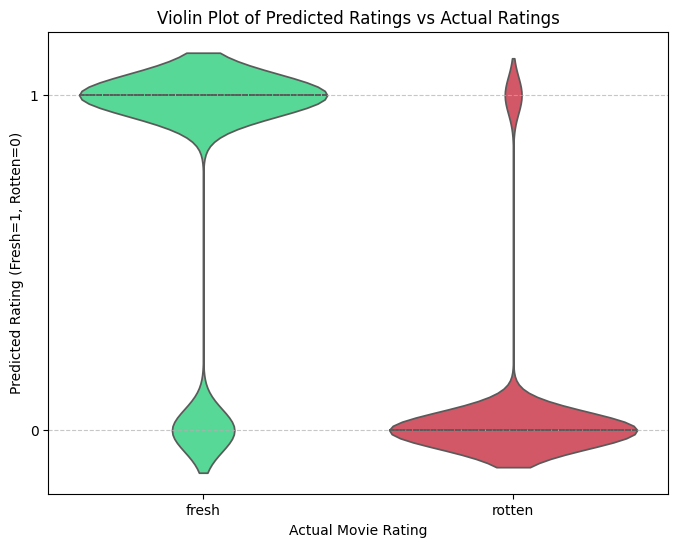

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=predictions_df_small,
    x='actual',
    y='predicted_numeric',
    palette=['#42ed95', '#e84357'],
    inner='quartile'
)
plt.title('Violin Plot of Predicted Ratings vs Actual Ratings')
plt.xlabel('Actual Movie Rating')
plt.ylabel('Predicted Rating (Fresh=1, Rotten=0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([0, 1])
plt.show()

The narrow deviation of the larger bell curves signifies that the vast majority of truly fresh rated films (as rated by the critics / users) were correctly identified as fresh, and even more frequently rotten films were correctly classified.  The smaller bell curves--the little bubbles--indicate false positives (films predicted to be considered fresh by critics, but that critics actually disliked and classified as rotten) as well as false negatives (films predicted to be considered rotten by critics, but that critics actually liked and classified as fresh).

# **Base Recommenders for Comparison**

In [ ]:
class RandomRecommender:
    def __init__(self, users_df):
        self.users_df = users_df

    def recommend(self, critic_name, n_recommendations):
        # Get all unique movies from users_df
        all_movies = self.users_df['movieTitle'].unique()

        # Randomly select n_recommendations movies
        recommended_movies = np.random.choice(all_movies, size=n_recommendations, replace=False)

        # Generate random states with 60% fresh and 40% rotten probability
        states = np.random.choice(['fresh', 'rotten'], size=n_recommendations, p=[0.6, 0.4])

        # Create recommendation DataFrame
        recommendations = pd.DataFrame({
            'movieTitle': recommended_movies,
            'reviewState': states
        })

        return recommendations

In [ ]:
class PopularRecommender:
    def __init__(self, users_df, items_df):
        self.users_df = users_df
        self.items_df = items_df

    def recommend(self, critic_name, n_recommendations=10):

        # Sort movies by gross earnings in descending order
        sorted_movies = self.items_df.sort_values('Gross', ascending=False)

        # Get top n_recommendations movies
        recommendations = sorted_movies.head(n_recommendations)

        # Create a new DataFrame with the index (movie titles) and gross earnings
        recommendations = pd.DataFrame({
            'movieTitle': recommendations.index,
            'Gross_Earnings': recommendations['Gross']
        })

        return recommendations

In [ ]:
import random
class CollaborativeRecommender:
    def __init__(self, users_df):
        self.users_df = users_df
        self.model = None
        self.reader = None
        self.trainset = None

        # Set random seeds for reproducibility with seed 1234
        np.random.seed(1234)
        random.seed(1234)

    def prepare_data(self):
        # Create a copy of the data
        df = self.users_df.copy()

        # Convert review states to numerical ratings
        df['rating'] = df['reviewState'].map({'fresh': 1, 'rotten': 0})

        # Create reader object
        self.reader = Reader(rating_scale=(0, 1))

        # Create surprise Dataset
        data = Dataset.load_from_df(df[['criticName', 'movieTitle', 'rating']], self.reader)

        # Build trainset
        self.trainset = data.build_full_trainset()

        return data

    def cross_validate(self, n_splits=5, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        # Prepare the data
        data = self.prepare_data()

        # Initialize the model
        self.model = SVD(n_factors=n_factors,
                        n_epochs=n_epochs,
                        lr_all=lr_all,
                        reg_all=reg_all,
                        random_state=1234)

        # Perform cross-validation
        results = cross_validate(self.model, data, measures=['RMSE', 'MAE'], cv=n_splits, verbose=True)

        return results

    def train(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        # Initialize and train the model with fixed random seed 1234
        self.model = SVD(n_factors=n_factors,
                        n_epochs=n_epochs,
                        lr_all=lr_all,
                        reg_all=reg_all,
                        random_state=1234)
        self.model.fit(self.trainset)

    def recommend(self, critic_name, n_recommendations=10):
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")

        # Get movies the critic has already reviewed
        critic_reviews = self.users_df[self.users_df['criticName'] == critic_name]['movieTitle'].unique()

        # Get all movies
        all_movies = self.users_df['movieTitle'].unique()

        # Get movies not reviewed by the critic
        movies_to_predict = [movie for movie in all_movies if movie not in critic_reviews]

        # Generate predictions
        predictions = []
        for movie in movies_to_predict:
            pred = self.model.predict(critic_name, movie)
            predictions.append({
                'movieTitle': movie,
                'predicted_rating': pred.est
            })

        # Convert to DataFrame and sort by predicted rating
        recommendations = pd.DataFrame(predictions)
        recommendations = recommendations.nlargest(n_recommendations, 'predicted_rating')

        # Add critic name column
        recommendations['criticName'] = critic_name

        # Reorder columns
        recommendations = recommendations[['criticName', 'movieTitle']]

        return recommendations

In [ ]:
#Example usage:
random_rec = RandomRecommender(users_df)
rec_rand = random_rec.recommend('James Berardinelli',10)
print(rec_rand)

                       movieTitle reviewState
0                    Fitzcarraldo      rotten
1                   Despicable Me       fresh
2           It Happened One Night       fresh
3        The Theory of Everything      rotten
4           The French Connection      rotten
5                     Blue Velvet       fresh
6  The Nightmare Before Christmas       fresh
7        In the Heat of the Night      rotten
8             The Boondock Saints       fresh
9               Kramer vs. Kramer       fresh


The random recommender generated 10 random movies and trying to get 60% "fresh" and 40% "rotten"

In [ ]:
# Example usage:
popular_rec = PopularRecommender(users_df, items_df)
rec_pop = popular_rec.recommend('James Berardinelli')
print(rec_pop)

                                            movieTitle  Gross_Earnings
movieTitle                                                            
Avengers: Endgame                    Avengers: Endgame     858373000.0
Avatar                                          Avatar     760507625.0
Avengers: Infinity War          Avengers: Infinity War     678815482.0
Titanic                                        Titanic     659325379.0
The Avengers                              The Avengers     623279547.0
Incredibles 2                            Incredibles 2     608581744.0
The Dark Knight                        The Dark Knight     534858444.0
The Dark Knight Rises            The Dark Knight Rises     448139099.0
E.T. the Extra-Terrestrial  E.T. the Extra-Terrestrial     435110554.0
Toy Story 4                                Toy Story 4     434038008.0


The popular recommender recommends the same top 10 movies based on gross earning

In [ ]:
# Example usage:
collab_rec = CollaborativeRecommender(users_df)

# Perform cross-validation
print("\nPerforming cross-validation...")
cv_results = collab_rec.cross_validate(n_splits=5)
print("\nCross-validation results:")
print(f"Average RMSE: {cv_results['test_rmse'].mean():.4f}")
print(f"Average MAE: {cv_results['test_mae'].mean():.4f}")

# Train the model and get recommendations
collab_rec.prepare_data()
collab_rec.train()
rec_cf = collab_rec.recommend('James Berardinelli')
print("\nTop 10 Movie Recommendations for", rec_cf['criticName'].iloc[0], ":\n")
print(rec_cf[['movieTitle']].to_string(index=False))


Performing cross-validation...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3151  0.3183  0.3138  0.3161  0.3207  0.3168  0.0024  
MAE (testset)     0.2027  0.2046  0.2008  0.2036  0.2056  0.2034  0.0017  
Fit time          2.06    1.18    1.30    1.16    1.15    1.37    0.35    
Test time         0.13    0.12    0.11    0.10    0.11    0.12    0.01    

Cross-validation results:
Average RMSE: 0.3168
Average MAE: 0.2034

Top 10 Movie Recommendations for James Berardinelli :

                      movieTitle
                    The 39 Steps
                Double Indemnity
                           Gilda
                            Rope
                   The Red Shoes
        A Streetcar Named Desire
                       Repulsion
                  Apocalypse Now
         Who Framed Roger Rabbit
What Ever Happened to Baby Jane?


# **Evaluations of All Recommenders**

In [ ]:
from sklearn.model_selection import train_test_split

# Encode ratings just in case (if needed for other evaluations)
users_df_encoded = users_df.copy()
users_df_encoded['rating'] = users_df_encoded['reviewState'].map({'fresh': 1, 'rotten': 0})

# Split train/test data
train_data, test_data = train_test_split(users_df_encoded, test_size=0.05, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error
import random

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_ndcg(user_name, recommended_movies, train_data, k=5):
    user_actual = train_data[(train_data['criticName'] == user_name)]
    user_ratings = user_actual.set_index('movieTitle')['reviewState'].map({'fresh': 1, 'rotten': 0}).to_dict()

    # Keep top-k recommended items with known ratings
    filtered = [movie for movie in recommended_movies if movie in user_ratings]
    if len(filtered) < k:
        return 0

    relevance_scores = [user_ratings[movie] for movie in filtered[:k]]
    ideal_scores = sorted(relevance_scores, reverse=True)

    dcg = np.sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores)])
    idcg = np.sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(ideal_scores)])
    return dcg / idcg if idcg != 0 else 0

## Random RS Results

In [ ]:
def calculate_coverage_random(random_rec, users_df, items_df, top_n=10):
    """Calculates coverage for the Random Recommender."""
    all_movie_ids = set(items_df['movieId'].unique())
    recommended_movie_ids = set()

    for user_name in users_df['criticName'].unique():
        recommendations = random_rec.recommend(user_name, top_n)
        recommended_movie_ids.update(items_df[items_df.index.isin(recommendations['movieTitle'])]['movieId'].values)

    coverage = len(recommended_movie_ids) / len(all_movie_ids)
    return coverage

def calculate_ndcg_random(random_rec, users_df, train_data, top_n=10):
    """Calculates NDCG for the Random Recommender."""
    all_users_ndcg = []

    # Select a subset of users (20% of unique users)
    num_users_to_sample = int(0.20 * len(users_df['criticName'].unique()))
    sampled_users = random.sample(list(users_df['criticName'].unique()), num_users_to_sample)

    for user_name in sampled_users:
        recommendations = random_rec.recommend(user_name, top_n)
        recommended_movies = recommendations['movieTitle'].tolist()

        # Get user's actual preferences (fresh movies)
        user_actual = users_df[(users_df['criticName'] == user_name) & (users_df['reviewState'] == 'fresh')]['movieTitle'].tolist()

        # Pass the 'user_name' and 'train_data' (or 'test_data' if that's intended) as arguments
        ndcg = calculate_ndcg(user_name, recommended_movies, train_data)  # Changed this line
        all_users_ndcg.append(ndcg)

    average_ndcg = np.mean(all_users_ndcg)
    return average_ndcg

def calculate_rmse(y_true, y_pred):
    """Calculates RMSE."""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def calculate_rmse_random(random_rec, users_df, train_data, top_n=10):
    """Calculates RMSE for the Random Recommender."""
    all_users_y_true = []
    all_users_y_pred = []

    # Select a subset of users (20% of unique users)
    num_users_to_sample = int(0.20 * len(users_df['criticName'].unique()))
    sampled_users = random.sample(list(users_df['criticName'].unique()), num_users_to_sample)

    for user_name in sampled_users:
        recommendations = random_rec.recommend(user_name, top_n)
        recommended_movies = recommendations['movieTitle'].tolist()

        # Get actual ratings for recommended movies, handling missing ratings
        y_true = []
        for movie in recommended_movies:
            actual_rating = users_df[(users_df['criticName'] == user_name) & (users_df['movieTitle'] == movie)]['reviewState'].values
            if len(actual_rating) > 0:
                # Convert 'fresh' and 'rotten' to numerical values (1 and 0)
                y_true.append(1 if actual_rating[0] == 'fresh' else 0)
            else:
                y_true.append(np.nan)  # Append NaN if no rating is found

        # Remove NaN values and adjust y_pred accordingly
        y_true_clean = [x for x in y_true if not np.isnan(x)]
        y_pred_clean = [1 if state == 'fresh' else 0 for state in recommendations['reviewState']]

        # Append to overall lists
        all_users_y_true.extend(y_true_clean)
        all_users_y_pred.extend(y_pred_clean[:len(y_true_clean)])  # Match y_pred length to y_true_clean

    # Calculate overall RMSE
    overall_rmse = calculate_rmse(all_users_y_true, all_users_y_pred)
    overall_mse = mean_squared_error(all_users_y_true, all_users_y_pred)
    return overall_rmse, overall_mse

In [ ]:
# Initialize Random Recommender
random_rec = RandomRecommender(train_data)  # ← use train_data instead of users_df for fairness

# Evaluate
coverage_random = calculate_coverage_random(random_rec, test_data, items_df)
ndcg_random = calculate_ndcg_random(random_rec, test_data, test_data)
rmse_random, mse_random = calculate_rmse_random(random_rec, test_data, test_data)

# Print results
print(f"Coverage (Random): {coverage_random:.2f}")
print(f"Average NDCG (Random): {ndcg_random:.2f}")
print(f"Overall RMSE (Random): {rmse_random:.2f}")
print(f"Overall MSE (Random): {mse_random:.2f}")

Coverage (Random): 1.00
Average NDCG (Random): 0.00
Overall RMSE (Random): 0.49
Overall MSE (Random): 0.24


<ipython-input-113-2879d2df1414>:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




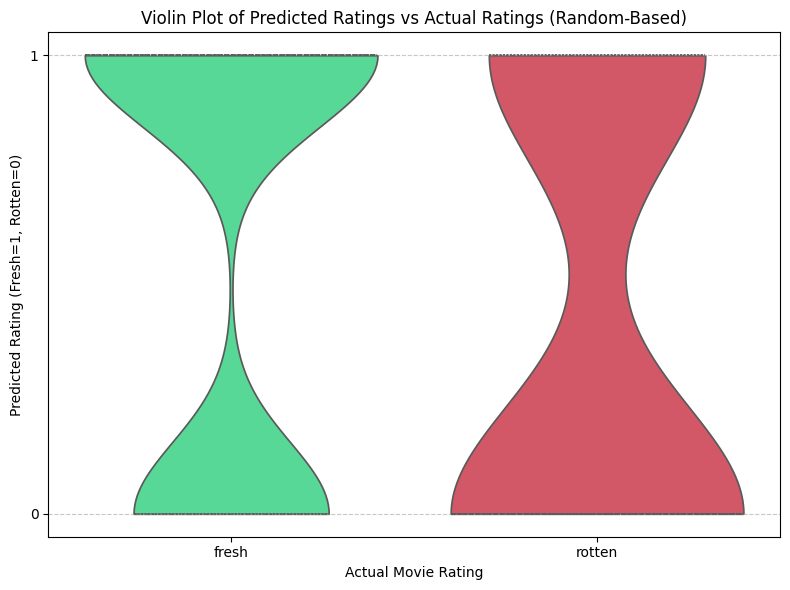

In [ ]:
# Limit to 500 unique users
unique_users = users_df_small['criticName'].unique()
sampled_users = np.random.choice(unique_users, size=min(500, len(unique_users)), replace=False)

# Filter users_df_small to just those sampled users
sampled_df = users_df_small[users_df_small['criticName'].isin(sampled_users)]

# Now use original logic on this smaller subset
predictions_random = []

for idx, row in sampled_df.iterrows():
    user = row['criticName']
    recommendations = random_rec.recommend(user, n_recommendations=10)

    for movie in recommendations['movieTitle']:
        predicted_rating = recommendations[recommendations['movieTitle'] == movie]['reviewState'].iloc[0]
        actual_rating = sampled_df[
            (sampled_df['criticName'] == user) &
            (sampled_df['movieTitle'] == movie)
        ]['reviewState'].values

        if len(actual_rating) > 0:
            predictions_random.append({
                'user': user,
                'movie': movie,
                'actual': actual_rating[0],
                'predicted': predicted_rating,
                'correct': actual_rating[0] == predicted_rating
            })

# Create DataFrame and encode
predictions_random_df = pd.DataFrame(predictions_random)
predictions_random_df['predicted_numeric'] = predictions_random_df['predicted'].map({'fresh': 1, 'rotten': 0})
predictions_random_df['actual_numeric'] = predictions_random_df['actual'].map({'fresh': 1, 'rotten': 0})

# Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=predictions_random_df,
    x='actual',
    y='predicted_numeric',
    palette=['#42ed95', '#e84357'],
    inner='quartile',
    cut=0
)
plt.title('Violin Plot of Predicted Ratings vs Actual Ratings (Random-Based)')
plt.xlabel('Actual Movie Rating')
plt.ylabel('Predicted Rating (Fresh=1, Rotten=0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([0, 1])
plt.tight_layout()
plt.show()


REFLECTION:

The Random Recommender, which generates movie suggestions by randomly predicting the rating of films (via the 60-40 distribution prevailing over the Rotten Tomatoes dataset), performed as expected, given it is uninformed and stochastic. Its coverage is perfect at 1.00, meaning it recommends every movie within the IMDb catalogue-—across users. This reflects the intended behavior of a random approach, offering maximum exposure to different titles without any filtering or targeting, but with the risk of making poor recommendation choices.

The NDCG score of 0.00 indicates that the ranked order of recommended movies had no meaningful alignment with user preferences. This is plausible although likely a coincidence, as the model does not consider any user metadata, movie content, or popularity-—the order is an arbitrary guesswork that may be completely wrong.

The RMSE (0.49) and MSE (0.24) are both considerably higher than those of the Popular or Content-Based recommenders. This makes sense given the model's lack of structure; by recommending movies indiscriminately, it is equally likely to suggest films a user liked or disliked, often getting the guess wrong.

In summary, the only advantage of the Random Recommender is its coverage, at the expense of high error and inaccurate ranking predictions, but it serves as a useful baseline to show us that the Content-based recommender (central to this project) outperforms it in every meaningful sector.

## Popular-Based RS Results

In [ ]:
def calculate_coverage_popular(popular_rec, users_df, items_df, top_n=10):
    """Calculates coverage for the Popular Recommender."""
    all_movie_ids = set(items_df['movieId'].unique())
    recommended_movie_ids = set()

    for user_name in users_df['criticName'].unique():
        recommendations = popular_rec.recommend(user_name, top_n)
        recommended_movie_ids.update(items_df[items_df.index.isin(recommendations['movieTitle'])]['movieId'].values)

    coverage = len(recommended_movie_ids) / len(all_movie_ids)
    return coverage

def calculate_ndcg_popular(popular_rec, users_df, train_data, top_n=10):
    """Calculates NDCG for the Popular Recommender."""
    all_users_ndcg = []

    # Select a subset of users (20% of unique users)
    num_users_to_sample = int(0.20 * len(users_df['criticName'].unique()))
    sampled_users = random.sample(list(users_df['criticName'].unique()), num_users_to_sample)

    for user_name in sampled_users:
        recommendations = popular_rec.recommend(user_name, top_n)
        recommended_movies = recommendations['movieTitle'].tolist()

        # Get user's actual preferences (fresh movies)
        user_actual = users_df[(users_df['criticName'] == user_name) & (users_df['reviewState'] == 'fresh')]['movieTitle'].tolist()

        # Pass the 'user_name' and 'train_data' (or 'test_data' if that's intended) as arguments
        ndcg = calculate_ndcg(user_name, recommended_movies, train_data)
        all_users_ndcg.append(ndcg)

    average_ndcg = np.mean(all_users_ndcg)
    return average_ndcg

def calculate_rmse_popular(popular_rec, users_df, train_data, top_n=10):
    """Calculates RMSE for the Popular Recommender."""
    all_users_y_true = []
    all_users_y_pred = []

    # subset of users (20% of unique users)
    num_users_to_sample = int(0.20 * len(users_df['criticName'].unique()))
    sampled_users = random.sample(list(users_df['criticName'].unique()), num_users_to_sample)

    for user_name in sampled_users:
        recommendations = popular_rec.recommend(user_name, top_n)
        recommended_movies = recommendations['movieTitle'].tolist()

        # Get actual ratings for recommended movies, handling missing ratings
        y_true = []
        for movie in recommended_movies:
            actual_rating = users_df[(users_df['criticName'] == user_name) & (users_df['movieTitle'] == movie)]['reviewState'].values # Access 'reviewState' instead of 'reviewState_numerical'
            if len(actual_rating) > 0:
                # Convert 'fresh' and 'rotten' to numerical values (1 and 0)
                y_true.append(1 if actual_rating[0] == 'fresh' else 0)
            else:
                y_true.append(np.nan)  # Append NaN if no rating is found

        # Remove NaN values and adjust y_pred accordingly
        y_true_clean = [x for x in y_true if not np.isnan(x)]
        y_pred_clean = [1] * len(y_true_clean)  # Assume popular movies are predicted as 'fresh' (1)

        # Append to overall lists
        all_users_y_true.extend(y_true_clean)
        all_users_y_pred.extend(y_pred_clean)

    # Calculate overall RMSE
    overall_rmse = calculate_rmse(all_users_y_true, all_users_y_pred)
    overall_mse = mean_squared_error(all_users_y_true, all_users_y_pred)
    return overall_rmse, overall_mse

In [ ]:
users_df_encoded = users_df.copy()
users_df_encoded['rating'] = users_df_encoded['reviewState'].map({'fresh': 1, 'rotten': 0})
train_data, test_data = train_test_split(users_df_encoded, test_size=0.05, random_state=42)

# Step 2: Initialize recommender using train_data
popular_rec = PopularRecommender(train_data, items_df)

# Step 3: Evaluate on test_data
coverage_popular = calculate_coverage_popular(popular_rec, test_data, items_df)
print(f"Coverage (Popular): {coverage_popular:.2f}")

ndcg_popular = calculate_ndcg_popular(popular_rec, test_data, test_data)
print(f"Average NDCG (Popular): {ndcg_popular:.2f}")

rmse_popular, mse_popular = calculate_rmse_popular(popular_rec, test_data, test_data)
print(f"Overall RMSE (Popular): {rmse_popular:.2f}")
print(f"Overall MSE (Popular): {mse_popular:.2f}")


Coverage (Popular): 0.01
Average NDCG (Popular): 0.00
Overall RMSE (Popular): 0.31
Overall MSE (Popular): 0.09


REFLECTION:

The Popular Recommender, which prioritizes high-grossing blockbuster films, performed mostly as expected across its evaluation metrics. Its coverage was extremely low at just 1%, indicating that only a tiny (the short head as opposed to the long tail) fraction of the entire movie catalog appeared in any user's recommendations. It repeatedly recommends an identical narrow set of top-earning films to all users.

The NDCG score was 0.00, perhaps this is random chance that the sample of critics it was measured up against all did not like the films that were at the top of the charts, or that the order was so misaligned that the result truncated to 0.  This indicates a complete mismatch between the model's output and the users' true "Fresh"/"Rotten" ratings.

While the RMSE (0.31) and MSE (0.09) are modest and quite better than random guessing, this should be interpreted with caution. The relatively low error is a misleading and only a byproduct of the recommender making “safe” predictions — it defaults to popular films that many critics rate positively--without real personalization or relevance.

In summary, this recommender has effectiveness in its simplicity and safety, however, the Popular Recommender is not successful at producing user-aligned or user-specific recommendations that cover the breadth of the movie dataset. Clearly, there are limitations to a one-size-fits-all approach solely based on commercial success.

## Content-Based RS Results

In [ ]:
# NDCG@5 Calculation
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    return np.sum((2**relevance_scores - 1) / np.log2(np.arange(2, relevance_scores.size + 2)))

def ndcg_at_k(recommended_movies, user_actual_ratings, k=5):
    relevance_scores = [user_actual_ratings.get(movie, 0) for movie in recommended_movies]
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    dcg = dcg_at_k(relevance_scores, k)
    idcg = dcg_at_k(ideal_relevance_scores, k)
    return dcg / idcg if idcg != 0 else 0

# Function to Evaluate NDCG for Randomly Selected Users
def evaluate_ndcg(users_df, hybrid_rank_df, num_users=10, min_reviews=20, k=5):
    users_with_enough_reviews = users_df['criticName'].value_counts()
    eligible_users = users_with_enough_reviews[users_with_enough_reviews >= min_reviews].index.tolist()

    sampled_users = random.sample(eligible_users, min(num_users, len(eligible_users)))

    ndcg_scores = []
    for user in sampled_users:
        user_reviews = users_df[users_df['criticName'] == user]
        fresh_movies = user_reviews[user_reviews['reviewState'] == 'fresh']['movieTitle'].tolist()

        if not fresh_movies:
            continue

        # Generate recommendations based on fresh movies
        sim_scores = hybrid_rank_df.loc[fresh_movies].mean().sort_values()
        recommended_movies = sim_scores.index.tolist()

        # Find top 5 recommended movies that user has rated
        user_rated_movies = user_reviews.set_index('movieTitle')['reviewState'].map({'fresh': 1, 'rotten': 0}).to_dict()

        final_recommended = []
        for movie in recommended_movies:
            if movie in user_rated_movies:
                final_recommended.append(movie)
                if len(final_recommended) == k:
                    break

        # Skip if less than k movies found
        if len(final_recommended) < k:
            continue

        ndcg = ndcg_at_k(final_recommended, user_rated_movies, k)
        ndcg_scores.append(ndcg)

    average_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0
    return average_ndcg

# Example Usage:
total_movies = items_df.shape[0]

average_ndcg = evaluate_ndcg(users_df, hybrid_rank_df)

print(f"Average NDCG@5: {average_ndcg:.4f}")

Average NDCG@5: 0.9956


In [ ]:
y_true, y_pred = [], []

for user in sampled_users:
    recommended_df, _ = get_user_recommendations(user, train_data, hybrid_rank_df, top_n=10)
    recommended_movies = recommended_df['movieTitle'].tolist()

    user_actual = test_data[test_data['criticName'] == user]

    for movie in recommended_movies:
        actual_rating = user_actual[user_actual['movieTitle'] == movie]['reviewState']
        if len(actual_rating) > 0:
            y_true.append(1 if actual_rating.iloc[0] == 'fresh' else 0)
            y_pred.append(1)  # recommended implies predicted fresh

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")


RMSE: 0.3835
MSE: 0.1471


In [ ]:
def calculate_coverage(recommended_movie_ids, all_movie_ids):
    return len(recommended_movie_ids) / len(all_movie_ids)

# Calculate coverage clearly using your training data recommendations
all_movie_ids = set(items_df['movieId'].unique())
recommended_movie_ids = set()

for user in sampled_users:
    recommended_df, _ = get_user_recommendations(user, train_data, hybrid_rank_df, top_n=10)
    recommended_movie_ids.update(items_df.loc[recommended_df['movieTitle'], 'movieId'])

coverage = calculate_coverage(recommended_movie_ids, all_movie_ids)

print(f"Coverage: {coverage:.4f}")

Coverage: 0.7338


<ipython-input-119-cb6762f3773d>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




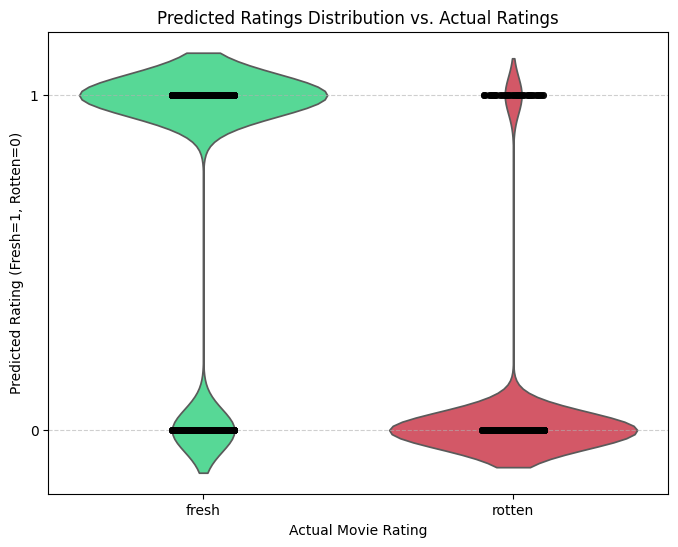

In [ ]:
predictions_df_small['predicted_numeric'] = predictions_df_small['predicted'].map({'fresh': 1, 'rotten': 0})
predictions_df_small['actual_numeric'] = predictions_df_small['actual'].map({'fresh': 1, 'rotten': 0})

plt.figure(figsize=(8,6))
sns.violinplot(
    data=predictions_df_small,
    x='actual',
    y='predicted_numeric',
    palette=['#42ed95', '#e84357'],
    inner=None
)
sns.stripplot(
    data=predictions_df_small,
    x='actual',
    y='predicted_numeric',
    color='black',
    jitter=True,
    size=5,
    alpha=0.5
)

plt.title('Predicted Ratings Distribution vs. Actual Ratings')
plt.xlabel('Actual Movie Rating')
plt.ylabel('Predicted Rating (Fresh=1, Rotten=0)')
plt.yticks([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

REFLECTION:

In terms of NDCG we can immediately see that it is near perfect, 0.996 (very close to 1), indicating that on average, for a Rotten Tomatoes critic (our users for this project), the ranked order proposed for those critics is near perfect, it will recommend almost all of the movies it (correctly) predicts the user will rate "Fresh" -- coded as 1, before it recommends a "Rotten" -- 0 film.

The coverage is also quite high, even as a content based recommender that narrows in on favorable categories for user-- nearly 3/4 of the films appear in some users' recommendations.

The errors, RMSE and MSE are both respectably low, and significantly lower thant he corresponding values for the random recommender (MSE being less sensitive to sway from outlier datapoints--users with very contradictory tastes or a lot of "Rotten's" for instance).  Note that these values are actually slightly lower (better) for the Popular recommender--however recall that the popular recommender (we define popular films as the big-budget-blockbusters) are usually well received by an overwhelming majority of critics, hence why they are "popular", and so when everyone rates a film "Fresh", and the popular recommender shows everyone this top 1% of cinema, it is almost always free of error.  Since ratings here are binary (like / dislike) there is much more chance of consensus if everyone has an inclination (as opposed to if ratings were on a 5-star scale).

Conversely, the content-based recommender. attempts to have a much greater breadth of recommendations, with more niche user-specific picks which may sometimes be wrong but perform error-wise quite closely to the popular recommender.